# Merging

Die Daten die wir wollen, kommen aus unterschiedlichen Quellen, bzw aus unterschiedlichen Sets von Kaggle. Wir können sie aber anhand des Spielnamens joinen. Der neue Datensatz besteht nur aus der Schnittmenge.
Wir verwenden die Folgenden Sets:

- Anzahl der Spieler und Spielpreis zu Release: https://www.kaggle.com/trolukovich/steam-games-complete-dataset

- Alles andere: https://www.kaggle.com/nikdavis/steam-store-games

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image

df_basis = pd.read_csv("data/steam_games.csv").dropna(how='any', axis=0, subset=['name'])
df_sales = pd.read_csv("data/steam_with_owner.csv").dropna(how='any', axis=0, subset=['name'])

df_basis["nameidx"] = [str(name).lower() for name in df_basis.name]
df_basis = df_basis.set_index(df_basis["nameidx"]).reindex()

df_sales["nameidx"] = [str(name).lower() for name in df_sales.name]
df_sales = df_sales.set_index(df_sales["nameidx"]).reindex()

df_merge = df_basis.merge(df_sales, left_index=True, right_index=True)

print(df_merge.shape)
df_merge[['name_x', 'name_y']].head(5)

(19694, 40)


,name_x,name_y
nameidx,,
"""butts: the vr experience""","""BUTTS: The VR Experience""","""BUTTS: The VR Experience"""
"""glow ball"" - the billiard puzzle game","""Glow Ball"" - The billiard puzzle game","""Glow Ball"" - The billiard puzzle game"
#archery,#Archery,#Archery
#cutesnake,#CuteSnake,#CuteSnake
#cutesnake 2,#CuteSnake 2,#CuteSnake 2


In [2]:
df_merge.columns

Index(['url', 'types', 'name_x', 'desc_snippet', 'recent_reviews',
       'all_reviews', 'release_date_x', 'developer_x', 'publisher_x',
       'popular_tags', 'game_details', 'languages', 'achievements_x', 'genre',
       'game_description', 'mature_content', 'minimum_requirements',
       'recommended_requirements', 'original_price', 'discount_price',
       'nameidx_x', 'appid', 'name_y', 'release_date_y', 'english',
       'developer_y', 'publisher_y', 'platforms', 'required_age', 'categories',
       'genres', 'steamspy_tags', 'achievements_y', 'positive_ratings',
       'negative_ratings', 'average_playtime', 'median_playtime', 'owners',
       'price', 'nameidx_y'],
      dtype='object')

Ab hier gilt es, die wichtigen Variablen zu halten und alles, was uns nicht interessiert fallen zu lassen. Der Fokus dieser Arbeit liegt auf der Bewertung und dadurch Prognose von Spielen gemessen an ihrer Beliebtheit, jedoch auch gemessen an ihrem Potential, Spieler anzuziehen, um sie auf der Plattform Steam zu halten. Für beide Zielgrößen müssen wir Features bauen. 

Für die Beliebtheit verwenden wir:
- popular_tags (identisch zu steamspy_tags)
- genres (ist identisch zu genre)
- categories (ist identisch zu game_details)
- positive ratings
- negative ratings

Für die Relevanz der Spiele verwenden wir:
- owners (gibt nur eine Range an. Muss überarbeitet werden)

Für beides verwenden wir:
- relese_date_y
- nameidx
- original_price

In [3]:
df = df_merge[["release_date_y","genres", "popular_tags", 'categories', 'negative_ratings', 'positive_ratings', 'owners', 'original_price']]

# Feature Engineering

### Neue Variable für Bliebtheit


Wir verweden in unserer Arbeit mehrere Filtermethoden, um "normale" Spiele von "guten" und "exzellenten" Spielen abzugrenzen. Dafür verwenden wir das Verhältnis der positiven zu den negativen Ratings. Um herauszufinden, wo wir am besten die Grenzen ziehen, plotten wir die Verteilung dieser Kennzahl.

<ipython-input-4-442fa18b72cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["avg_owners"] = (df.owners.str.split("-", expand=True).astype('int')[1] - df.owners.str.split("-", expand=True).astype('int')[0])/2


count    1.969400e+04
mean     1.308689e+03
std      2.218296e+04
min      0.000000e+00
25%      7.000000e+00
50%      2.900000e+01
75%      1.740000e+02
max      2.644404e+06
Name: positive_ratings, dtype: float64

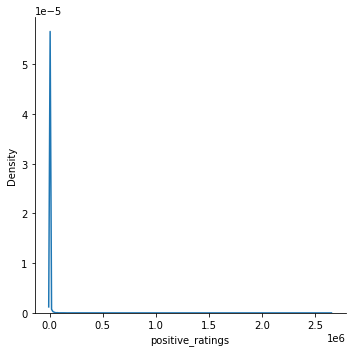

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# definiere "owners"
df["avg_owners"] = (df.owners.str.split("-", expand=True).astype('int')[1] - df.owners.str.split("-", expand=True).astype('int')[0])/2

# Wir schauen nach, ob wir anhand der Owner- und Pos_Rating-Veteilung eine Trennlinie ziehen können.
sns.displot(df, x="positive_ratings", kind="kde")
df["positive_ratings"].describe()

In [5]:
for share in [.5, .7, .75, .8, .85, .9, .95, .96, .97, .98, .99, .995, .999, .9999]:
    quantile=df["positive_ratings"].quantile(share)
    print(f"number of positive ratings in {share} quantile: {quantile}")

number of positive ratings in 0.5 quantile: 29.0
number of positive ratings in 0.7 quantile: 115.0
number of positive ratings in 0.75 quantile: 174.0
number of positive ratings in 0.8 quantile: 279.0
number of positive ratings in 0.85 quantile: 496.0499999999993
number of positive ratings in 0.9 quantile: 1069.7000000000007
number of positive ratings in 0.95 quantile: 3177.399999999994
number of positive ratings in 0.96 quantile: 4340.75999999998
number of positive ratings in 0.97 quantile: 6185.669999999976
number of positive ratings in 0.98 quantile: 10015.14
number of positive ratings in 0.99 quantile: 20770.07
number of positive ratings in 0.995 quantile: 36259.28
number of positive ratings in 0.999 quantile: 138987.80700000175
number of positive ratings in 0.9999 quantile: 526551.1795997713


In [6]:
for share in [.5, .7, .75, .8, .85, .9, .95, .96, .97, .98, .99, .995, .999, .9999]:
    quantile=df["avg_owners"].quantile(share)
    print(f"number of avg_owners in {share} quantile: {quantile}")

number of avg_owners in 0.5 quantile: 10000.0
number of avg_owners in 0.7 quantile: 15000.0
number of avg_owners in 0.75 quantile: 15000.0
number of avg_owners in 0.8 quantile: 25000.0
number of avg_owners in 0.85 quantile: 50000.0
number of avg_owners in 0.9 quantile: 150000.0
number of avg_owners in 0.95 quantile: 150000.0
number of avg_owners in 0.96 quantile: 250000.0
number of avg_owners in 0.97 quantile: 250000.0
number of avg_owners in 0.98 quantile: 500000.0
number of avg_owners in 0.99 quantile: 1500000.0
number of avg_owners in 0.995 quantile: 1500000.0
number of avg_owners in 0.999 quantile: 5000000.0
number of avg_owners in 0.9999 quantile: 25000000.0


Wir probieren es einfach mal ab dem 50-%-Perzentil der avg_owner.

In [7]:
df = df[df.avg_owners > df["avg_owners"].quantile(.5)].dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6650 entries, "glow ball" - the billiard puzzle game to 魔物讨伐团
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   release_date_y    6650 non-null   object 
 1   genres            6650 non-null   object 
 2   popular_tags      6650 non-null   object 
 3   categories        6650 non-null   object 
 4   negative_ratings  6650 non-null   int64  
 5   positive_ratings  6650 non-null   int64  
 6   owners            6650 non-null   object 
 7   original_price    6650 non-null   object 
 8   avg_owners        6650 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 519.5+ KB


count    6650.000000
mean        0.746703
std         0.170842
min         0.000000
25%         0.654347
50%         0.784946
75%         0.879639
max         1.000000
Name: pos_rating_share, dtype: float64

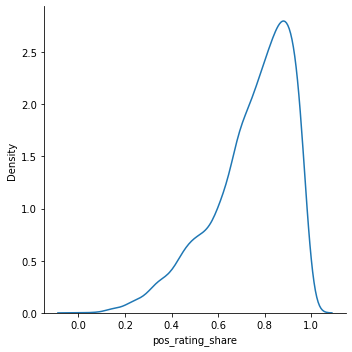

In [8]:
df["pos_rating_share"] = df["positive_ratings"] / (df["negative_ratings"] + df["positive_ratings"])

sns.displot(df, x="pos_rating_share", kind="kde")
df["pos_rating_share"].describe()

Da wir nun eine genauere Vorstellung von unserer Zielvariablen haben, können wir passende Label bilden, indem wir angemessene Grenzen ziehen:
- "good": .5 - .75 Perzentil. Das entspricht bereits einem Anteil von positiven Bewertungen von ca 85%
- "very good": .75 - .95 Perzentil
- "extremely good": .95 - 1. Perzentil

In [9]:
good_lower = df["pos_rating_share"].quantile(.5)
good_upper = df["pos_rating_share"].quantile(.75)
very_good_upper = df["pos_rating_share"].quantile(.95)

filter_method = lambda x: 'good' if (x >= good_lower and x < good_upper) else 'very_good' if (x >= good_upper and x < very_good_upper) else 'extremely_good' if x > very_good_upper else 'bad'

df["rating"] = df["pos_rating_share"].apply(filter_method)
df["rating"].value_counts()

bad               3324
good              1663
very_good         1330
extremely_good     333
Name: rating, dtype: int64

### Neue Variable: tags

Der Datensatz enthält 3 Spalten, die ein Spiel lediglich anhand mehrerer einzelner Wörter beschreiben wollen:

- popular_tags
- genres
- categories

Die neue Variable "tags" verbindet all diese Spalten in eine einzige und lässt nur die 7 populärsten tags für jeden Titel darin zu. 

In [10]:
df[["popular_tags", "genres", "categories"]].head(3)

,popular_tags,genres,categories
nameidx,,,
"""glow ball"" - the billiard puzzle game","Indie,Casual,Strategy,Sports",Casual;Indie;Sports;Strategy,Single-player;Steam Trading Cards;Partial Cont...
#archery,"Indie,Sports,VR",Indie;Sports,Single-player;Local Multi-Player;Steam Achieve...
#have a sticker,"Casual,Strategy,Puzzle,Free to Play,Singleplay...",Casual;Strategy,Single-player;Steam Achievements


In [11]:
df.popular_tags.str.split(",", expand = True).isna().sum()

0        0
1       25
2      172
3      556
4     1033
5     1509
6     1917
7     2285
8     2640
9     2957
10    3244
11    3497
12    3754
13    3990
14    4186
15    4356
16    4549
17    4691
18    4844
19    4982
dtype: int64

In [12]:
# Nur die ersten beiden Category behalten. 
df["category"] = df.categories.str.split(";", expand = True )[0] # ab 2. Cat gibts 10% NaN-Werte

# Nur das erste Genre behalten. 
df["genre"] = df.genres.str.split(";", expand = True )[0] # ab 2. Gen gibts 20% NaN-Werte

# Nur die ersten 7 Tags behalten. Spiele, die da schon NaN-Werte haben, fliegen raus
df["tags"] = [";".join(df.popular_tags.str.split(",")[i][:7]) for i in  range(df.shape[0])] 

# Die nächsten 2 Zeilen sind lediglich ein Filter-DF. 
df_tags = df.popular_tags.str.split(",", expand=True).loc[:, :7] 
df = df[~df_tags.isna().any(axis=1)]

# Säubern
df = df.drop(["genres","categories","popular_tags","negative_ratings", "positive_ratings", "pos_rating_share"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4365 entries, #have a sticker to 甜点恋人 / pastry lovers
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   release_date_y  4365 non-null   object 
 1   owners          4365 non-null   object 
 2   original_price  4365 non-null   object 
 3   avg_owners      4365 non-null   float64
 4   rating          4365 non-null   object 
 5   category        4365 non-null   object 
 6   genre           4365 non-null   object 
 7   tags            4365 non-null   object 
dtypes: float64(1), object(7)
memory usage: 306.9+ KB


### Neue Variablen: release_price und avg_owners

Das wird eine vollends geschätzte Sales-Variable, die vielen Annahmen unterliegt:
- Die Anzahl der Besitzer entspricht dem Schnitt aus deren Ober- und Untergrenze ("owners" ist immer als Intervall angegeben wie z.b. 10000-20000)
- Der "original_price" war der zum release_date und ist in Dollar angegeben.
- Spiele-Demos werden entfernt

In [13]:
# lösche demos
df = df[~df.original_price.str.lower().str.strip("$").str.contains("demo")]

# Setze Preis = 0 für free-to-play-Spiele. 
free_filter = df.original_price.str.lower().str.strip("$").str.contains("free")
df["original_price"] = df.original_price.where(~free_filter, other = '0.00').str.strip("$")

# Alle Zeilen, deren Preis ich nicht in eine Zahl übersetzen kann, fliegen raus. 
df["release_price"] = pd.to_numeric(df.original_price.str.strip("$"), errors = 'coerce')
df = df.dropna()

# Säubern
df["release_date"] = df["release_date_y"]
df = df.drop(["owners", "release_date_y", "original_price"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4323 entries, #have a sticker to 甜点恋人 / pastry lovers
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   avg_owners     4323 non-null   float64
 1   rating         4323 non-null   object 
 2   category       4323 non-null   object 
 3   genre          4323 non-null   object 
 4   tags           4323 non-null   object 
 5   release_price  4323 non-null   float64
 6   release_date   4323 non-null   object 
dtypes: float64(2), object(5)
memory usage: 270.2+ KB


In [14]:
df.to_csv("data/steam_zwischenspeichern.csv")

In [15]:
df = df.reset_index()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   nameidx        4323 non-null   object 
 1   avg_owners     4323 non-null   float64
 2   rating         4323 non-null   object 
 3   category       4323 non-null   object 
 4   genre          4323 non-null   object 
 5   tags           4323 non-null   object 
 6   release_price  4323 non-null   float64
 7   release_date   4323 non-null   object 
dtypes: float64(2), object(6)
memory usage: 270.3+ KB


In [17]:
df.columns = ['title', 'avg_owners', 'rating', 'category', 'genre', 'tags','release_price', 'release_date']

In [18]:
df_tag = df.tags.str.split(";", expand=True)
df_tag.columns =["tag_1", "tag_2", "tag_3", "tag_4", "tag_5", "tag_6", "tag_7"]

df = pd.concat([df[["rating", 'avg_owners', "title", 'release_price', 'release_date', 'category', 'genre']], df_tag.reset_index(drop=True)], axis=1)

In [19]:
df.to_csv("data/Datenanlyse.csv", index=False)

### Zeitindex einbauen

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("data/steam_preprocessed_many_tag_cols.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rating         4323 non-null   object 
 1   avg_owners     4323 non-null   float64
 2   title          4323 non-null   object 
 3   release_price  4323 non-null   float64
 4   release_date   4323 non-null   object 
 5   category       4323 non-null   object 
 6   genre          4323 non-null   object 
 7   tag_1          4323 non-null   object 
 8   tag_2          4323 non-null   object 
 9   tag_3          4323 non-null   object 
 10  tag_4          4323 non-null   object 
 11  tag_5          4323 non-null   object 
 12  tag_6          4323 non-null   object 
 13  tag_7          4323 non-null   object 
dtypes: float64(2), object(12)
memory usage: 473.0+ KB


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'release_date')

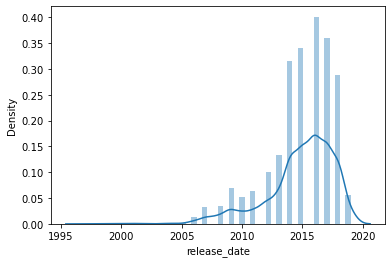

In [22]:
sns.distplot(df.release_date.str.split("-", expand=True)[0], kde=True)
plt.xlabel("release_date")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='release_price'>

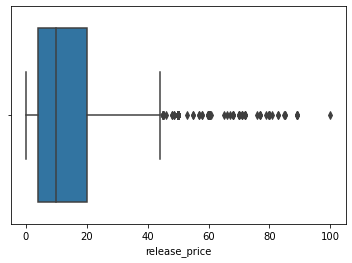

In [26]:
sns.boxplot(df[df.release_price < 100].release_price)


In [28]:
df[df.release_price < 100].release_price.mean()

13.442515179822148

In [31]:
import datetime

# realease_date soll auf Tage verzichten
df["release_date"] = pd.to_datetime(["-".join(df.release_date.str.split("-")[i][:2]) for i in  range(df.shape[0])])
df = df.set_index('release_date').sort_index()
df.index

DatetimeIndex(['1997-06-01', '1998-11-01', '1999-04-01', '1999-11-01',
               '2000-11-01', '2000-11-01', '2001-03-01', '2001-06-01',
               '2001-06-01', '2001-12-01',
               ...
               '2019-04-01', '2019-04-01', '2019-04-01', '2019-04-01',
               '2019-04-01', '2019-04-01', '2019-04-01', '2019-04-01',
               '2019-04-01', '2019-04-01'],
              dtype='datetime64[ns]', name='release_date', length=4323, freq=None)

In [32]:
df[df['rating'] == "extremely_good"]['2010'] # einfach nur um zu schauen, ob die bisherigen Filtermethoden intuitive Ergebnisse liefern. 

,rating,avg_owners,title,release_price,category,genre,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7
release_date,,,,,,,,,,,,,
2010-02-01,extremely_good,500000.0,s.t.a.l.k.e.r.: call of pripyat,19.99,Single-player,Action,Atmospheric,Open World,Post-apocalyptic,FPS,Survival,Action,Singleplayer
2010-03-01,extremely_good,1500000.0,batman: arkham asylum game of the year edition,19.99,Single-player,Action,Action,Batman,Stealth,Third Person,Adventure,Superhero,Singleplayer
2010-03-01,extremely_good,1500000.0,mount & blade: warband,19.99,Single-player,Action,Medieval,RPG,Open World,Strategy,Sandbox,Action,Multiplayer
2010-09-01,extremely_good,500000.0,vvvvvv,4.99,Single-player,Action,Platformer,Indie,Great Soundtrack,Difficult,Retro,2D,Pixel Graphics
2010-09-01,extremely_good,150000.0,recettear: an item shop's tale,19.99,Single-player,RPG,Capitalism,Anime,RPG,Dungeon Crawler,JRPG,Indie,Singleplayer
2010-09-01,extremely_good,2500000.0,sid meier's civilization® v,29.99,Single-player,Strategy,Turn-Based Strategy,Strategy,Turn-Based,Multiplayer,Historical,4X,Addictive
2010-10-01,extremely_good,1500000.0,fallout: new vegas,9.99,Single-player,Action,Open World,RPG,Post-apocalyptic,Singleplayer,Moddable,Exploration,First-Person
2010-12-01,extremely_good,150000.0,bejeweled® 3,4.99,Single-player,Strategy,Puzzle,Casual,Match 3,Singleplayer,Strategy,Addictive,Relaxing


----

### EXKURS: Category und Genre machen den Anschein, als würden sie nur wenige Infos liefern. Überprüfen und ggf entfernen. 



In [33]:
df.category.value_counts()

Single-player                 3964
Multi-player                   243
Online Multi-Player             73
MMO                             23
Steam Achievements               6
Local Multi-Player               5
Steam Trading Cards              2
Partial Controller Support       2
Co-op                            1
Shared/Split Screen              1
Full controller support          1
Cross-Platform Multiplayer       1
Steam Workshop                   1
Name: category, dtype: int64

In [34]:
df.genre.value_counts()

Action                   2101
Adventure                 851
Indie                     355
Casual                    291
RPG                       141
Strategy                  130
Free to Play              127
Simulation                113
Violent                    71
Racing                     50
Sexual Content             43
Nudity                     24
Animation & Modeling        7
Sports                      7
Massively Multiplayer       4
Gore                        4
Design & Illustration       2
Utilities                   2
Name: genre, dtype: int64

In [35]:
for col in df.columns:
    try: 
        df[col] = df[col].str.lower().str.replace("-","").str.strip()
    except:
        pass
df.head()

,rating,avg_owners,title,release_price,category,genre,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7
release_date,,,,,,,,,,,,,
1997-06-01,very_good,25000.0,carmageddon max pack,9.99,singleplayer,action,racing,action,classic,indie,gore,1990's,masterpiece
1998-11-01,extremely_good,2500000.0,halflife,9.99,singleplayer,action,fps,classic,action,scifi,singleplayer,masterpiece,shooter
1999-04-01,good,2500000.0,team fortress classic,4.99,multiplayer,action,action,fps,multiplayer,classic,shooter,teambased,classbased
1999-11-01,very_good,2500000.0,halflife: opposing force,4.99,singleplayer,action,fps,action,classic,scifi,singleplayer,shooter,firstperson
2000-11-01,extremely_good,5000000.0,counterstrike,9.99,multiplayer,action,action,fps,multiplayer,shooter,classic,teambased,firstperson


In [36]:
# Categories checken

df["cat_in_tags"] = (df.category == df.tag_1) | (df.category == df.tag_2) | (df.category == df.tag_3) | (df.category == df.tag_4) | (df.category == df.tag_5) | (df.category == df.tag_6) | (df.category == df.tag_7)
cat = round((df["cat_in_tags"].sum() / df.shape[0]) * 100, 2) 
print(f"Anteil der Spiele, bei denen category in tags vorkommt: {cat} %") 

not_bad_cat = round(((df[~df["cat_in_tags"]]['rating'] == "bad").sum() / df.shape[0]) *100,2)
print(f"Anteil der nicht-schlechten Spiele, deren category nicht in tags vorkommt: {not_bad_cat} %")
df = df.drop("cat_in_tags", axis=1)

print("\n")


# Genres checken

df["gen_in_tags"] = (df.genre == df.tag_1) | (df.genre == df.tag_2) | (df.genre == df.tag_3) | (df.genre == df.tag_4) | (df.genre == df.tag_5) | (df.genre == df.tag_6) | (df.genre == df.tag_7)
gen = round((df["gen_in_tags"].sum() / df.shape[0]) * 100, 2) 
print(f"Anteil der Spiele, bei denen genres in tags vorkommt: {gen} %") 

not_bad_gen = round(((df[~df["gen_in_tags"]]['rating'] == "bad").sum() / df.shape[0]) *100,2)
print(f"Anteil der nicht-schlechten Spiele, deren genre nicht in tags vorkommt: {not_bad_gen} %")

df = df.drop("gen_in_tags", axis=1)

Anteil der Spiele, bei denen category in tags vorkommt: 29.56 %
Anteil der nicht-schlechten Spiele, deren category nicht in tags vorkommt: 28.68 %


Anteil der Spiele, bei denen genres in tags vorkommt: 87.12 %
Anteil der nicht-schlechten Spiele, deren genre nicht in tags vorkommt: 4.33 %


Da steht im Prinzip: Der Anteil der guten, sehr guten und extrem guten Spiele, deren Genre nicht bereits in den Tags steht, liegt bei gerade einmal 4.33%. Bei allen anderen Spielen, die in dieser Arbeit als nicht-schlecht erachtet werden, steht das Genre nochmal in den Tags.

### ERGEBNIS: Die Category spielt eine Rolle, weil sie bei den nicht-schelchten Spielen in den Tags seltener genannt wird. Das Genre hingegen wird in der genannten Gruppe beinahe immer in den Tags wiedergespiegelt und enthält daher kaum Informationsgewinn  

----

In [37]:
df = df.drop("genre", axis=1)

----

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4323 entries, 1997-06-01 to 2019-04-01
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rating         4323 non-null   object 
 1   avg_owners     4323 non-null   float64
 2   title          4323 non-null   object 
 3   release_price  4323 non-null   float64
 4   category       4323 non-null   object 
 5   tag_1          4323 non-null   object 
 6   tag_2          4323 non-null   object 
 7   tag_3          4323 non-null   object 
 8   tag_4          4323 non-null   object 
 9   tag_5          4323 non-null   object 
 10  tag_6          4323 non-null   object 
 11  tag_7          4323 non-null   object 
dtypes: float64(2), object(10)
memory usage: 439.1+ KB


# Wörterbuch basteln

In diesem Schritt geht es darum, jedes Spiel als Vektor anhand all seiner tags und seiner category auszudrücken, um ein KNIME dann in kNN-Modell anwenden zu können.   

In [39]:
df_text = df[["category", "tag_1", "tag_2", "tag_3", "tag_4", "tag_5", "tag_6", "tag_7"]] 

In [40]:
def make_unique(liste):
    '''
    
    '''
    mid_set = set()
    return_liste = []

    for element in liste:
        mid_set.add(element)

    for i in mid_set:
        return_liste.append(i)
    
    return(return_liste)

test_liste = 'a,a,b,c'.split(',')

make_unique(test_liste)

['b', 'a', 'c']

In [41]:
# erstellt ein leeres dictionary. Jedes Wort (wenn noch nicht in keys) wird ein neuer Key im dict und erhält eine leere Liste als Wert. 
# Anschließend wird über alle Textbestandteile iteriert. 

word_dict = {}

for rowIndex, row in df_text.iterrows(): #iterate over rows
    for columnIndex, value in row.items():
        if value not in word_dict.keys():
            word_dict[value] = []

counter = 0

for ridx,row in df_text.iterrows():
    
    counter += 1
    
    # Es gibt ein Problem mit doppelt vorkommenden tags. Lösung: row-Liste zu set und zurück zu Liste. So bleiben nur einzigartige Werte. 
    
    row_list = make_unique(row.tolist())

    for word in row_list:
        
        if word in word_dict.keys():
                word_dict[word].append(1)
    
    for liste in list(word_dict.values()): 
        if len(liste) < counter:
            liste.append(0)
            
len(word_dict['singleplayer']) == df_text.shape[0] # hats funktioniert?

True

In [42]:
df_dict = pd.DataFrame.from_dict(word_dict)
df_dict

,singleplayer,racing,action,classic,indie,gore,1990's,masterpiece,fps,scifi,...,diplomacy,hockey,nonlinear,conversation,battle royale,experience,faith,skating,tutorial,pve
0,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4318,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4319,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4320,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4321,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Das wars. 

df_dict.index = df.index
df_to_concat= df[['rating', 'avg_owners','title','release_price']]
df_concat = pd.concat([df_to_concat, df_dict], axis=1)
df_concat.shape
df_concat = df_concat.reset_index()
df_concat["release_date"] = df_concat["release_date"].astype('str').str.split("-", expand=True)[0].astype('int')

In [44]:
df_concat["release_date"]

0       1997
1       1998
2       1999
3       1999
4       2000
        ... 
4318    2019
4319    2019
4320    2019
4321    2019
4322    2019
Name: release_date, Length: 4323, dtype: int32

In [45]:
df_concat.to_csv("data/predictive analysis.csv")

In [46]:
df_concat

,release_date,rating,avg_owners,title,release_price,singleplayer,racing,action,classic,indie,...,diplomacy,hockey,nonlinear,conversation,battle royale,experience,faith,skating,tutorial,pve
0,1997,very_good,25000.0,carmageddon max pack,9.99,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1998,extremely_good,2500000.0,halflife,9.99,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1999,good,2500000.0,team fortress classic,4.99,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1999,very_good,2500000.0,halflife: opposing force,4.99,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2000,extremely_good,5000000.0,counterstrike,9.99,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4318,2019,extremely_good,15000.0,phoenix wright: ace attorney trilogy / 逆転裁判123...,29.99,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4319,2019,very_good,250000.0,totally accurate battle simulator,14.99,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4320,2019,extremely_good,25000.0,lovers of aether,0.00,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4321,2019,good,15000.0,driftland: the magic revival,29.99,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
